### 필요한 모델 임포트

In [8]:
import torch
from torch import nn
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np




### 초기값, 시간범위 지정

In [9]:
# 중력 가속도
g = 9.81

# 초기 위치와 속도
h0 = 10.0
v0 = 5.0

# 시간 범위
t_span = torch.linspace(0, 1, 100)


### 바람

### FINN + NeuralODE 적용한 신경망 모델 + 그래프


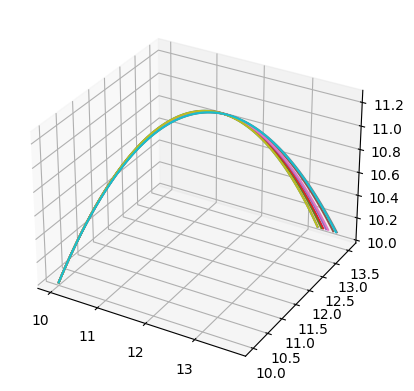

In [10]:
class ODEFunc(nn.Module):
    def __init__(self, g=9.8, wind=0):
        super(ODEFunc, self).__init__()
        self.g = g
        self.wind = nn.Parameter(torch.tensor(wind, dtype=torch.float32))

    def forward(self, t, y):
        x, y, z, vx, vy, vz = torch.split(y, 1, dim=1)
        dxdt = vx
        dydt = vy
        dzdt = vz
        dvxdt = self.wind * torch.ones_like(vx)
        dvydt = torch.zeros_like(vy)
        dvzdt = -self.g * torch.ones_like(vz)
        return torch.cat((dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt), dim=1)


# 초기 조건
y0 = torch.tensor([[h0, h0, h0, v0 / np.sqrt(2), v0 / np.sqrt(2), v0]])




# 그래프 설정
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 시뮬레이션 횟수(나중에 데이터셋이 있다면 train 을 돌리는 방식)
num_trajectories = 10

# 바람 조건
wind_values = np.random.uniform(low=-0.5, high=0.5, size=(num_trajectories,))

# 시뮬레이션
for i in range(num_trajectories):
    # Define the vector field function for each trajectory
    vector_field = ODEFunc(g=g, wind=wind_values[i])

    # Neural ODE model
    neural_ode = NeuralODE(vector_field, sensitivity='autograd', solver='dopri5')
    
    # Simulate trajectory
    trajectory = neural_ode.trajectory(y0, t_span).detach()

    # Plot trajectory
    ax.plot(trajectory[:, 0, 0].numpy(), trajectory[:, 0, 1].numpy(), trajectory[:, 0, 2].numpy())

plt.show()

## 공이 떨어진 위치 표시